<a href="https://colab.research.google.com/github/tirsodelrey/22-23-1-PR-PR1-DED/blob/master/tfg_uoc_tdelrey.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
!pip install timm==0.6.13
!pip install transformers
import timm
import fastai
import pandas as pd
import seaborn as sns
from fastai import *
from fastai.vision import *
from fastai.vision.all import *
from fastai.data.all import *
from transformers import AutoImageProcessor, ConvNextV2ForImageClassification

sns.set(color_codes = True)


In [ ]:
!pip install kaggle

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
path = '/content/drive/MyDrive/Colab Notebooks/TFG/HAM10000'

In [4]:
cd /content/drive/MyDrive/Colab Notebooks/TFG/HAM10000

/content/drive/MyDrive/Colab Notebooks/TFG/HAM10000


In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"tirsogumb","key":"5431d5a7692395bb93376b6ac6923b82"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!rm kaggle.json



In [ ]:
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000

100% 5.20G/5.20G [04:18<00:00, 23.2MB/s]
100% 5.20G/5.20G [04:18<00:00, 21.6MB/s]


###Funciones auxiliares

###Inferencia

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import balanced_accuracy_score

In [ ]:
def inference(learn):
  tst_dl = learn.dls.test_dl(tst_files)
  preds,_ = learn.tta(dl=tst_dl)
  #probs,_,idxs = learn.get_preds(dl=tst_dl, with_decoded=True)
  idxs = preds.argmax(dim=1)
  vocab = np.array(learn.dls.vocab)
  results = pd.Series(vocab[idxs], name="idxs")
  ground_truth = pd.read_csv(path+'/test_ground_truth.csv')
  ground_truth['dx'] = ground_truth['dx'].str.lower().map(short_to_full_name_dict)
  targets = pd.Series(ground_truth['dx'])
  # accuracy: (tp + tn) / (p + n)
  accuracy = accuracy_score(targets, results)
  # precision tp / (tp + fp)
  precision = precision_score(targets, results, average='weighted')
  # recall: tp / (tp + fn)
  recall = recall_score(targets, results, average='weighted')
  # f1: 2 tp / (2 tp + fp + fn)
  f1 = f1_score(targets, results, average='weighted')
  #balanced accuracy
  balanced_accuracy = balanced_accuracy_score(targets, results)

  #average accuracy
  print('accuracy: %f' % accuracy)
  print('precision: %f' % precision)
  print('Recall: %f' % recall)
  print('F1 score: %f' % f1)
  print('Balanced accuracy: %f' % balanced_accuracy)


##**Exploración de los datos**

###Carga y procesamiento

In [5]:
train_path = path +'/train_images'
test_path = path + '/test_images'

Descomprimimos el dataset descargado directamente de la fuente oficial de Kaggle a nuestro directorio de trabajo.

In [ ]:
!unzip "/content/drive/MyDrive/Colab Notebooks/TFG/HAM10000/skin-cancer-mnist-ham10000.zip" -d train_path

unzip:  cannot find or open /content/drive/MyDrive/Colab Notebooks/TFG/HAM10000/skin-cancer-mnist-ham10000.zip, /content/drive/MyDrive/Colab Notebooks/TFG/HAM10000/skin-cancer-mnist-ham10000.zip.zip or /content/drive/MyDrive/Colab Notebooks/TFG/HAM10000/skin-cancer-mnist-ham10000.zip.ZIP.


Ahora que las imágenes se encuentran en el directorio de trabajo, obtenemos una lista de ellas.


In [ ]:
files = get_image_files(train_path)

Y observamos una de ellas para hacernos una idea de la estructura general:

(600, 450)


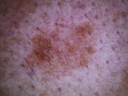

In [ ]:
img = PILImage.create(files[0])
print(img.size)
img.to_thumb(128)

Parece ser que las imágenes serán 600*450. Para asegurarnos. Comprobaremos todas las medidas de manera paralelizada utilizando la librería fastcore.parallel:

In [ ]:
from fastcore.parallel import *

def f(o): return PILImage.create(o).size
sizes = parallel(f, files, n_workers=8)
pd.Series(sizes).value_counts()

(600, 450)    10015
dtype: int64

Tenemos 10.015 imágenes, todas del mismo tamaño, esto es importante ya que si no la librería de fastai sería incapaz de crear *batches* y tendríamos que aplicar una transformación que iguale el tamaño de todas. Posteriormente también aplicaremos transformaciones

Descargamos también el conjunto de test

In [ ]:
tst_files = get_image_files(test_path).sorted()

Ahora procedamos a hacer una exploración de los datos de estudio cargando los datos presentes en el csv HAM10000_metadata, que como su propio nombre indica, contine los metadatos, esto es, la información que describe el conjunto de datos de entrenamiento.

In [6]:
df = pd.read_csv(path+'/HAM10000_metadata.csv')
df.head()

lesion_id      image_id   dx dx_type   age   sex localization
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear

Observamos que los metadatos nos proporcionan información que relaciona los identificadores de las imágenes, que hemos descargado en train_images, con la información sobre la enfermedad como diagnóstico (dx) tipo de muestra (dx_type), edad, sexo o localización. No obstante, los códigos de los diagnósticos no son muy descriptivos, por lo que crearemos un diccionario que permita relacionar cada código con el tipo de lesión que referencia.

In [7]:
# Diccionario para mapear abreviaturas a nombres completos de lesiones
short_to_full_name_dict = {
    "akiec": "bowen's disease",
    "bcc": "basall cell carcinoma",
    "bkl": "benign keratosis-like lesions",
    "df": "dermatofibroma",
    "mel": "melanoma",
    "nv": "melanocytic nevi",
    "vasc": "vascular lesions",
}


In [8]:
# Reemplazar abreviaturas por nombres completos en la columna 'tipo_lesion'
df['lesion_type'] = df['dx'].map(short_to_full_name_dict)

In [9]:
df.head()

lesion_id      image_id   dx dx_type   age   sex localization  \
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp   
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp   
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp   
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp   
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear   

                     lesion_type  
0  benign keratosis-like lesions  
1  benign keratosis-like lesions  
2  benign keratosis-like lesions  
3  benign keratosis-like lesions  
4  benign keratosis-like lesions

A continuación crearemos un diccionario que nos permita relacionar cada identificador de imagen con el tipo de lesión (tipo_lesión), que utilizaremos más adelante como etiqueta.

In [10]:
# Crear el diccionario que relaciona cada imagen con su enfermedad
id_disease_dict = dict(zip(df['image_id'], df['lesion_type']))

Y definimos una función que nos permita obtener las etiquetas (labels) de las imágenes del directorio

In [11]:
# Definir una función para obtener las etiquetas (enfermedades) de las imágenes
def get_label(file_path):
    file_name = file_path.name
    image_id = file_name.split('.')[0]  # Obtener el ID de la imagen
    disease = id_disease_dict.get(image_id)  # Obtener la enfermedad asociada al ID
    return disease

###Limpieza de los datos

Buscamos si existen valores nulos:

In [12]:
df.isnull().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age             57
sex              0
localization     0
lesion_type      0
dtype: int64

Solo el atributo edad tiene, valores nulos, que sustituiremos por la media

In [13]:
df['age'].fillna((df['age'].mean()), inplace=True)

###Análisis exploratorio

In [14]:
print(df.lesion_type.value_counts())

melanocytic nevi                 6705
melanoma                         1113
benign keratosis-like lesions    1099
basall cell carcinoma             514
bowen's disease                   327
vascular lesions                  142
dermatofibroma                    115
Name: lesion_type, dtype: int64


A continuación observamos un diagrama con representación del número de muestras en términos absolutos en función del tipo de lesión.

In [22]:
sns.set(font_scale = 1.25)

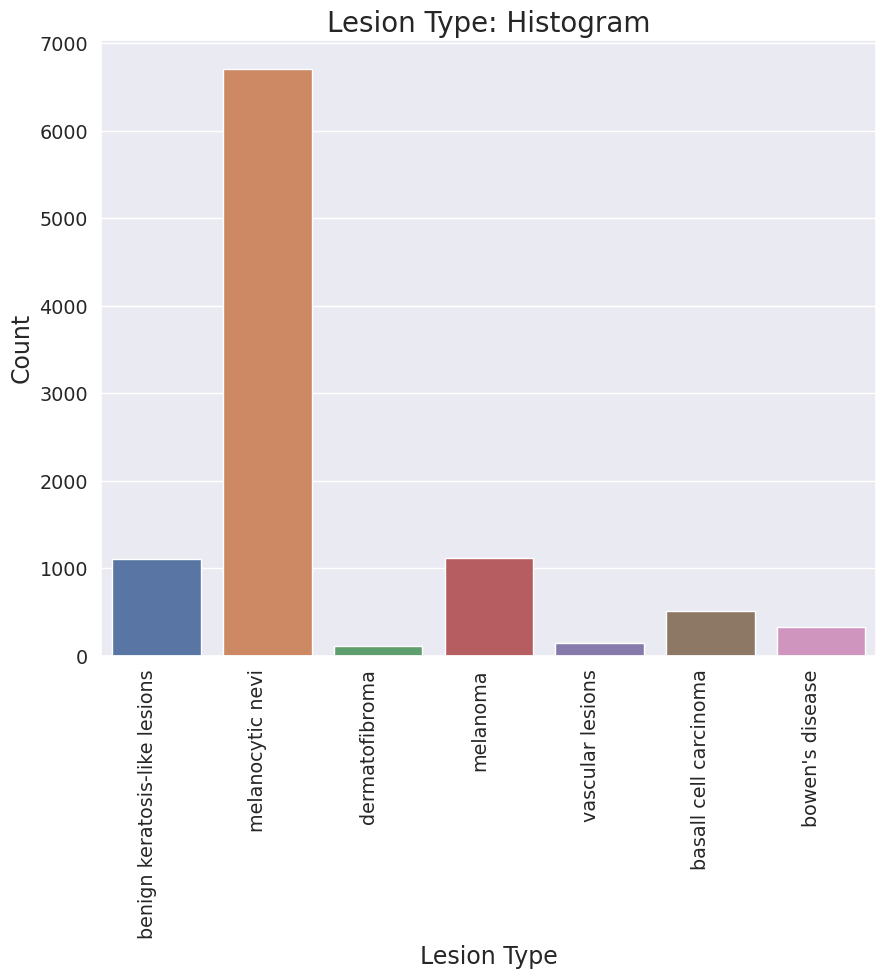

In [29]:
# Distribución de las categorías de cáncer de piel
plt.figure(figsize=(10, 8))
ax = sns.countplot(x="lesion_type", data=df)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")  # Rotar las etiquetas
plt.xlabel("Lesion Type", fontsize=17)
plt.ylabel("Count", fontsize=17)
plt.title("Lesion Type: Histogram", fontsize=20)
plt.show()

Se trata de una dataset notablemente desequilibrado, con un gran número de muestras de nevo melanocítico, comunmente conocido como lunar, que aglutina más de la mitad de las muestras del dataset. Las siguientes muestras más frecuentes son el melanoma y la queratosis benigna.

Exploramos el resto de datos que nos ofrece el conjunto:

Tipo de diagnóstico:

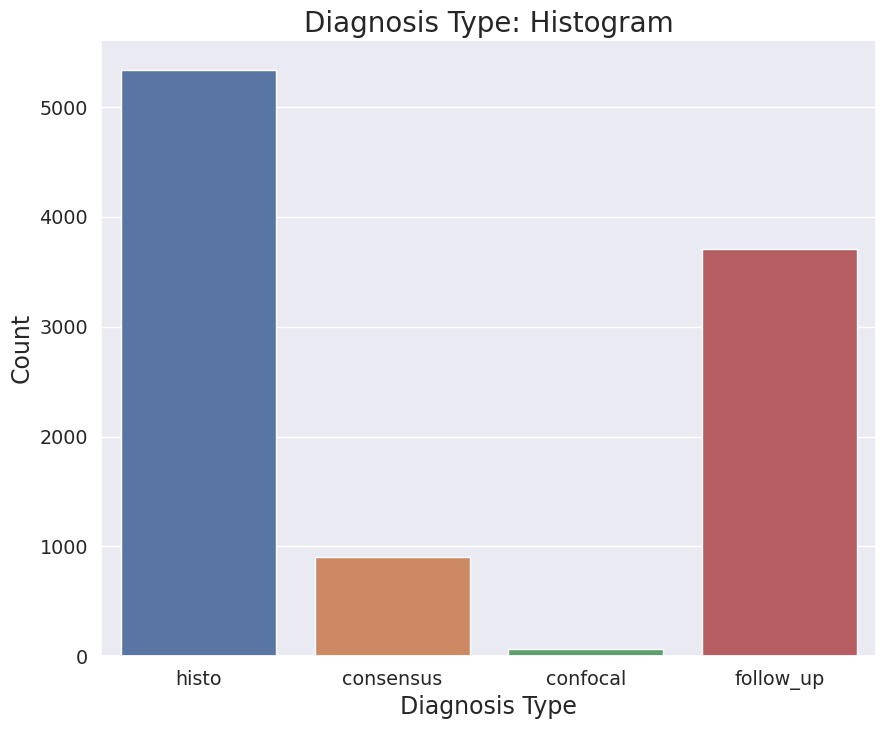

In [25]:
# Diagnosis del tipo de diagnóstico
plt.figure(figsize=(10, 8))
sns.countplot(x="dx_type", data=df)
plt.xlabel("Diagnosis Type", fontsize=17)
plt.ylabel("Count", fontsize=17)
plt.title("Diagnosis Type: Histogram", fontsize=20)
plt.show()


Localización de la lesión:

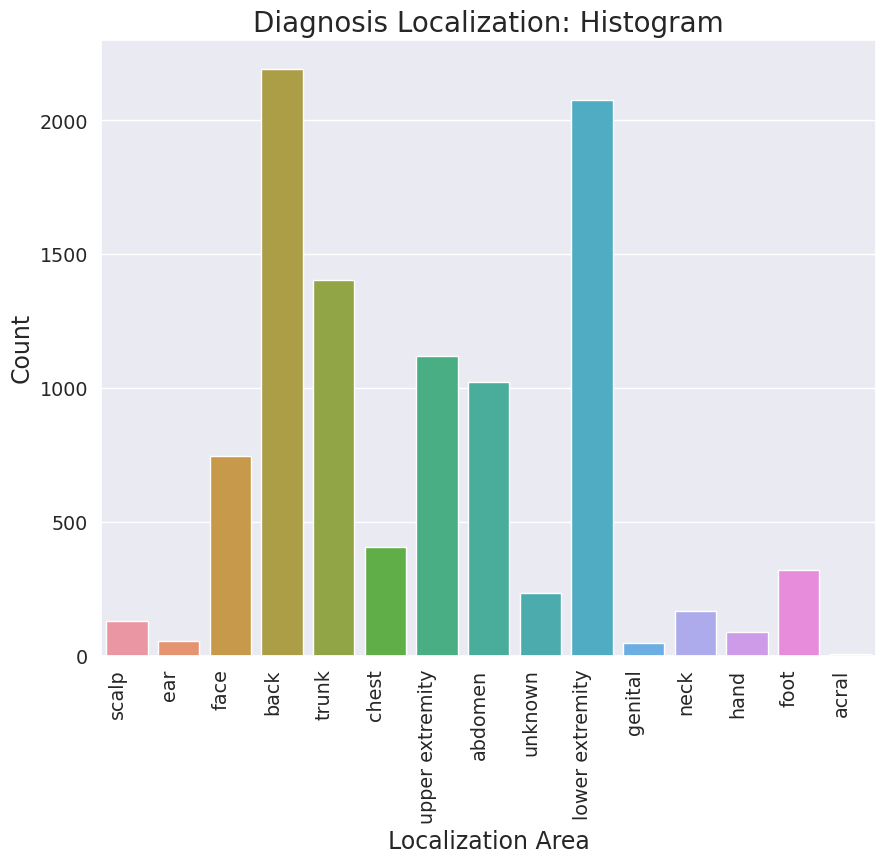

In [33]:
#Distribución de la localización de la lesión
plt.figure(figsize=(10, 8))
ax = sns.countplot(x="localization", data=df)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")  # Rotar las etiquetas
plt.xlabel("Localization Area", fontsize=17)
plt.ylabel("Count", fontsize=17)
plt.title("Diagnosis Localization: Histogram", fontsize=20)
plt.show()

Distribución de la edad:

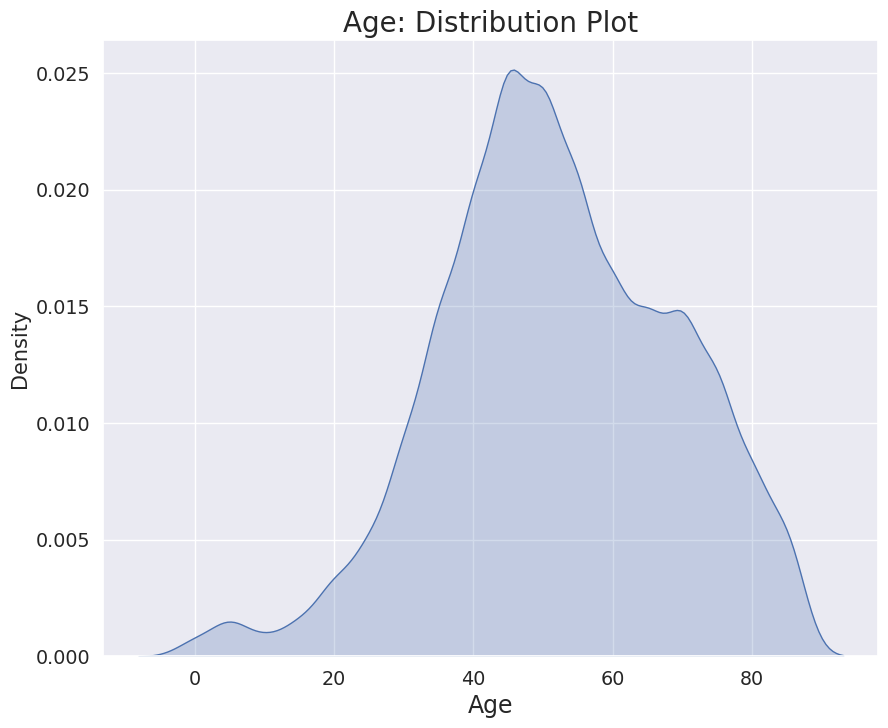

In [24]:
#Distribución de la edad
plt.figure(figsize=(10, 8))
sns.kdeplot(df["age"], legend=False, fill=True)
plt.xlabel("Age", fontsize=17)
plt.title("Age: Distribution Plot", fontsize=20)
plt.show()




Distribución de géneros:

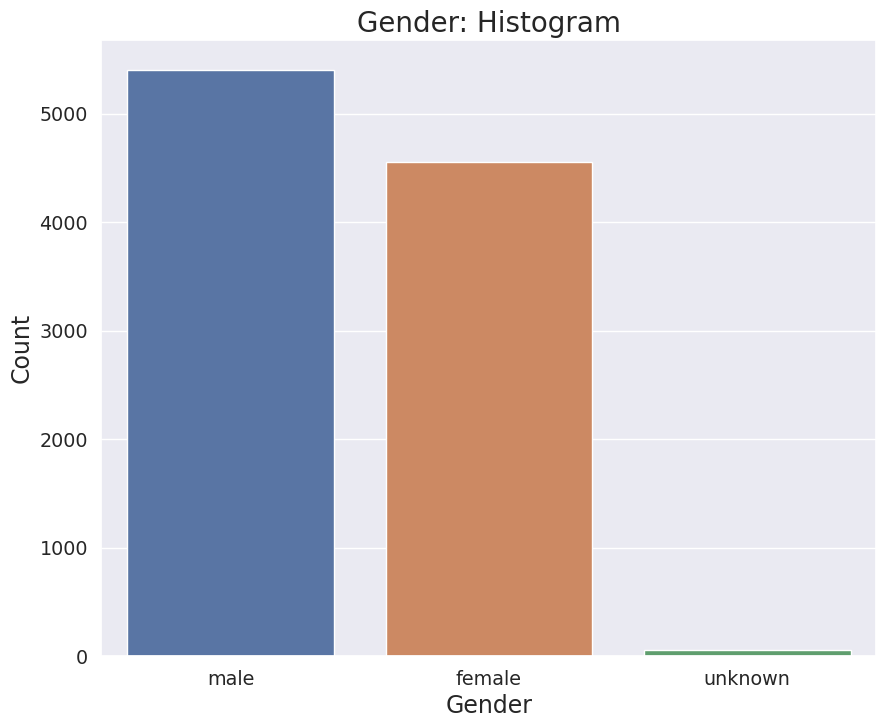

In [34]:
# Distribución de géneros
plt.figure(figsize=(10, 8))
sns.countplot(x="sex", data=df)
plt.xlabel("Gender", fontsize=17)
plt.title("Gender: Histogram", fontsize=20)
plt.ylabel("Count", fontsize=17)
plt.show()

Una vez explorado el dataset, pasamos al procesamiento de los datos. Para poder en un principio procesarlos de manera más rápida, utilizaremos algunas de las funciones de la API data block de fastai, que permite aglutinar diversas clases de PyTorch en una.




##**Primer modelo**

Definimos una estructura de Datablock de la API de fastai que nos permite definir:


*   El tipo de elemento de los bloques (Imagen y categoría)
*   La randomización del conjunto inicial en un conjunto de entrenamiento (80%) y validación (20%). Definimos un seed (42) para garantizar la reproductibilidad.


*   Definimos la función que permite obtener las etiquetas de las imágenes.
*   Reescalamos las imágenes a 480*480 para el entrenamiento por lotes (batch_tfms) al que se aplicará además el aumento (aug_transforms) no se pierda información útil.





In [ ]:
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=get_label,
    item_tfms=Resize(450),
    batch_tfms=aug_transforms(size=128, min_scale=0.75)
  )

In [ ]:
dblock.summary(train_path)

Setting-up type transforms pipelines
Found 10015 items
2 datasets of sizes 8012,2003
Setting up Pipeline: PILBase.create
Setting up Pipeline: get_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      /content/drive/MyDrive/Colab Notebooks/TFG/HAM10000/train_images/ham10000_images_part_2/ISIC_0032838.jpg
    applying PILBase.create gives
      PILImage mode=RGB size=600x450
  Pipeline: get_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      /content/drive/MyDrive/Colab Notebooks/TFG/HAM10000/train_images/ham10000_images_part_2/ISIC_0032838.jpg
    applying get_label gives
      melanocytic nevi
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(3)

Final sample: (PILImage mode=RGB size=600x450, TensorCategory(3))


Found 10015 items
2 datasets of sizes 8012,2003
Setting up Pipeline: PILBase.create
Setting up P

Si se inspecciona aug_transforms() se pueden observar algunas de las transformaciones aplicadas como Flip (voltear la imagen) o Brightness (iluminación)

In [ ]:
aug_transforms()

[Flip -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 0.5}:
 encodes: (TensorImage,object) -> encodes
 (TensorMask,object) -> encodes
 (TensorBBox,object) -> encodes
 (TensorPoint,object) -> encodes
 decodes: ,
 Brightness -- {'max_lighting': 0.2, 'p': 1.0, 'draw': None, 'batch': False}:
 encodes: (TensorImage,object) -> encodes
 decodes: ]

Cargamos el DataBlock en un dataloader indicando el directorio donde se encuentran el conjunto de entrenamiento.

In [ ]:
dls = dblock.dataloaders(train_path)

fastai permite ver el conjunto de entrenamiento tras aplicar las transformaciones. Este es un ejemplo del funcionamiento de la técnica de aumento, que genera varias copias transformadas de una imagen original.

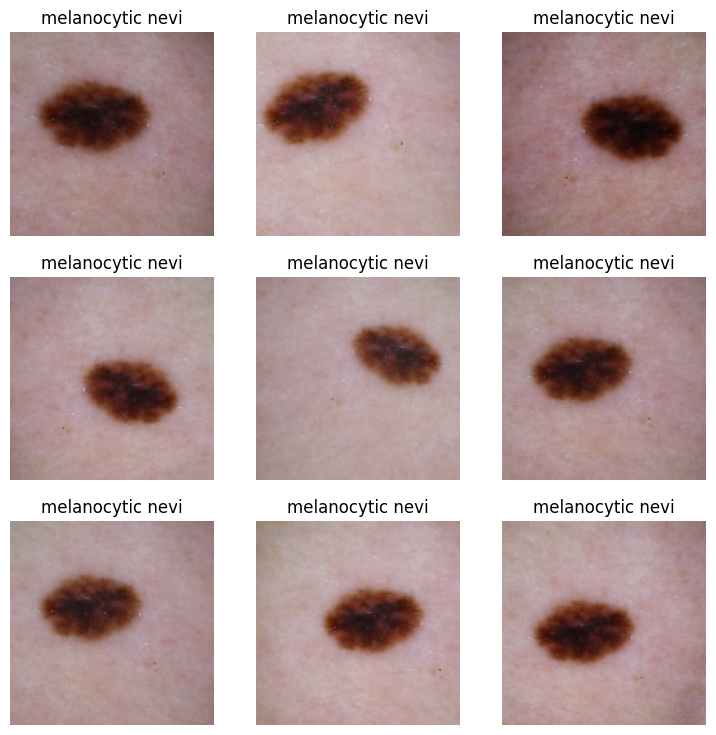

In [ ]:
dls.show_batch(unique=true)

Se puede extraer también una muestra  de uno de los lotes de entrenamiento:

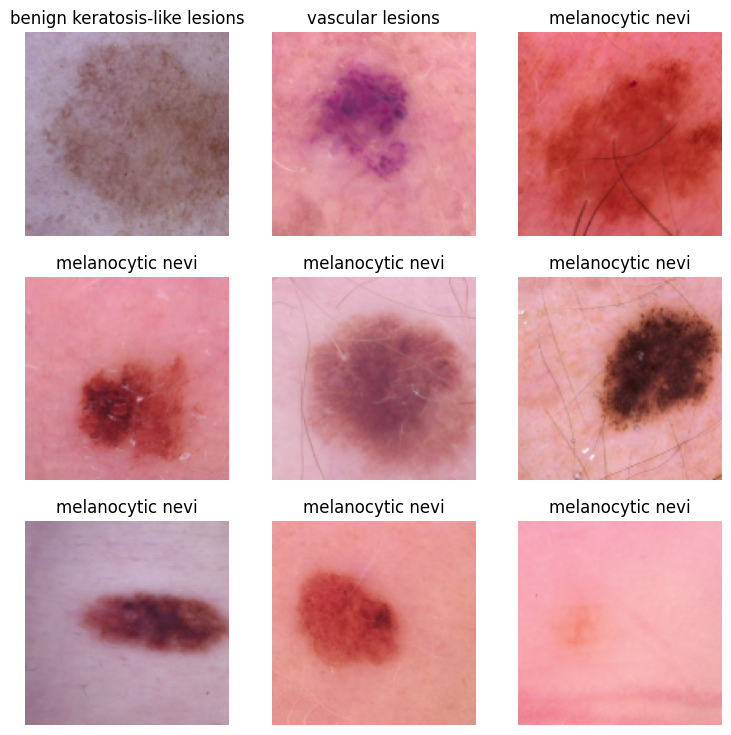

In [ ]:
dls.show_batch()

Se configura el objeto Learner con la arquitectura y las métricas que queremos obtener.

In [ ]:
learn = vision_learner(dls, 'resnet26d', metrics=[error_rate, accuracy], path='.').to_fp16()

model.safetensors:   0%|          | 0.00/64.2M [00:00<?, ?B/s]

Utilizamos la función lr_find para obtener la tasa de aprendizaje recomendada.

SuggestedLRs(valley=0.0014454397605732083, slide=0.009120108559727669)

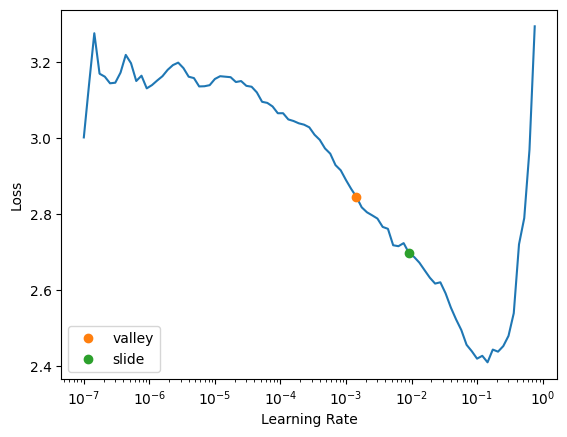

In [ ]:
learn.lr_find(suggest_funcs=(valley, slide))

Enterenamos el modelo con la tasa de entrenamiento recomendada (0.01)

In [ ]:
learn.fine_tune(5, 0.01)

**Resultados:**

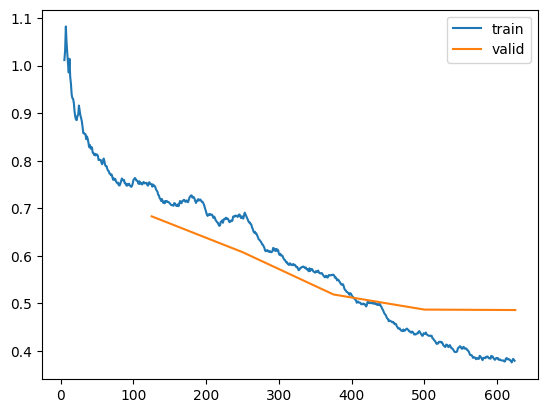

In [ ]:
learn.recorder.plot_loss()

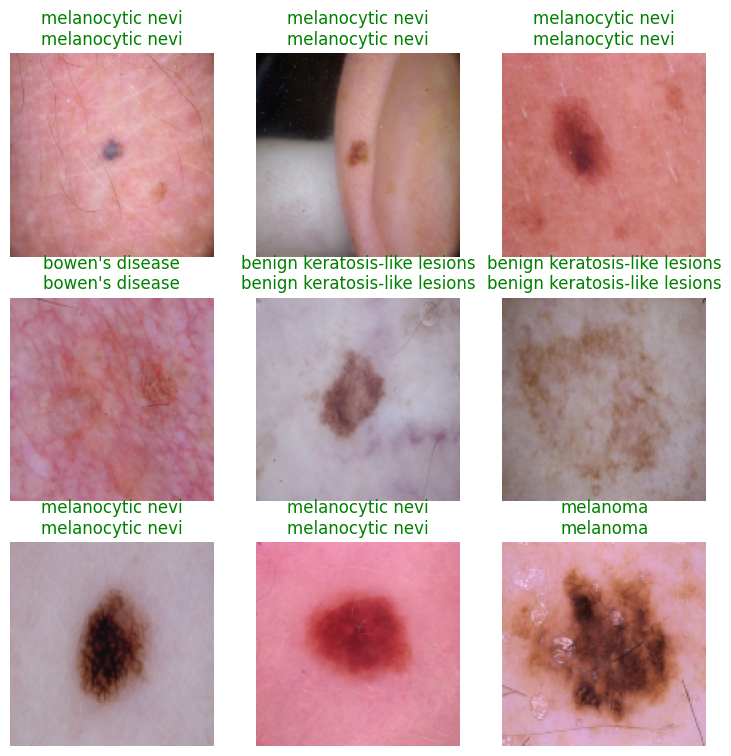

In [ ]:
learn.show_results()

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

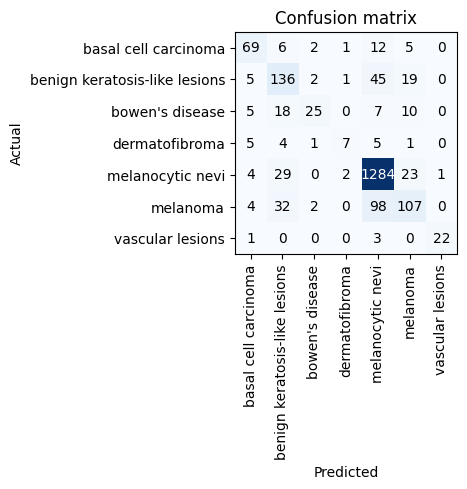

In [ ]:
interp.plot_confusion_matrix()

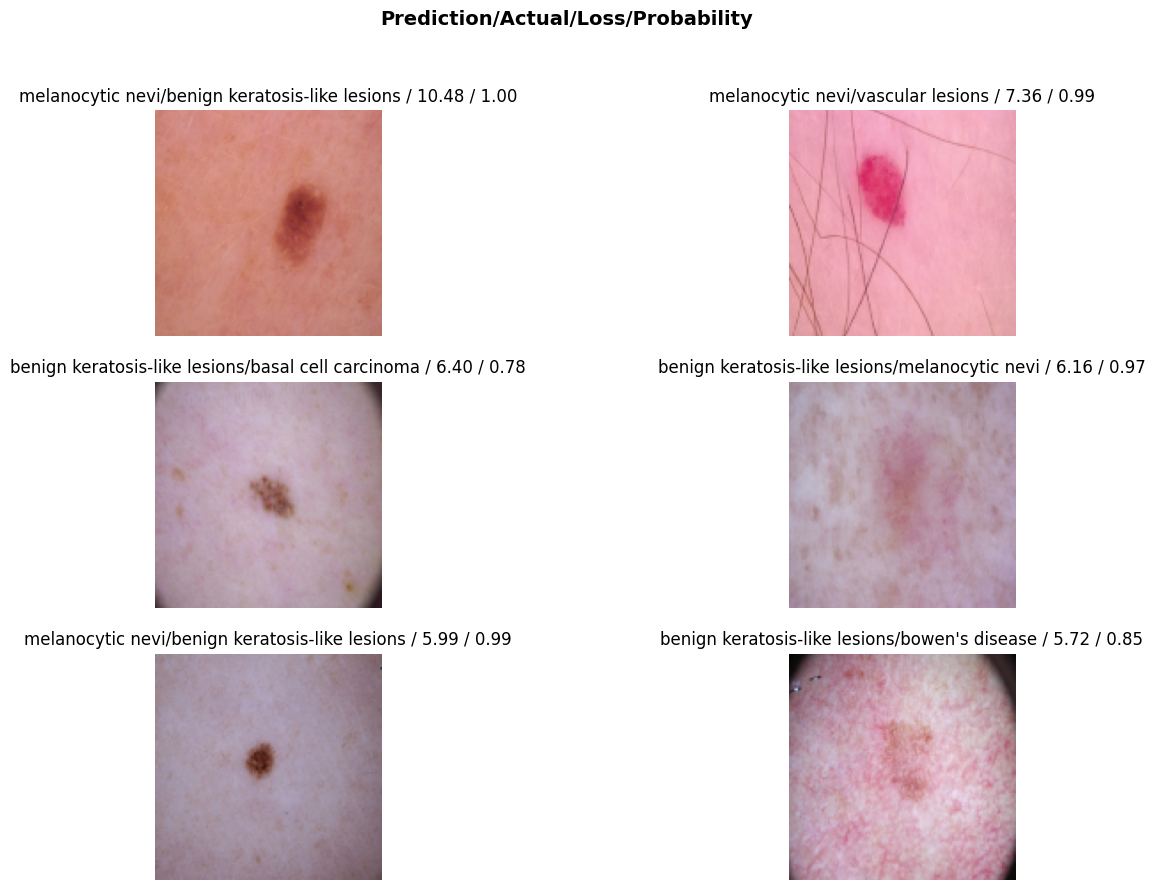

In [ ]:
interp.plot_top_losses(6, nrows=3, figsize=(15,10))

Exportamos el modelo por si queremos utilizarlo más adelante:

In [ ]:
learn.export('resnet26d-baseline.pkl')

Probamos el modelo con el conjunto de test:

In [ ]:
learner = load_learner('resnet26d-baseline.pkl')

In [ ]:
inference(learner)

Accuracy: 0.737434
Precision: 0.714662
Recall: 0.737434
F1 score: 0.719674


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


##**Iteración y optimización con modelos pequeños**

Definimos una función que nos sirva como plantilla para ir probando diferentes arquitecturas y estrategias de procesamiento de datos

In [ ]:
def train(arch, item, batch, lr=0.01, epochs=5):
    dls = DataBlock(
      blocks=(ImageBlock, CategoryBlock),
      get_items=get_image_files,
      splitter=RandomSplitter(valid_pct=0.2, seed=42),
      get_y=get_label,
      item_tfms=item,
      batch_tfms=batch).dataloaders(train_path)
    learn = vision_learner(dls, arch, metrics=[error_rate, accuracy], path='.').to_fp16()
    learn.fine_tune(epochs, lr)
    return learn

Comparamos las arquitecturas resnet y convnext utilizando los mismos parámetros

###ResNet

In [ ]:
arch = 'resnet26d'

In [ ]:
learn = train(arch, item=Resize(256), batch=aug_transforms(size=128, min_scale=0.75))

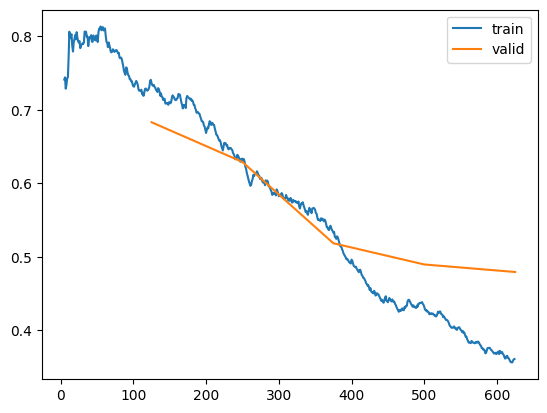

In [ ]:
learn.recorder.plot_loss()

In [ ]:
learn = train(arch, item=Resize(256), batch=RandomResizedCrop(size=128, min_scale=0.75))

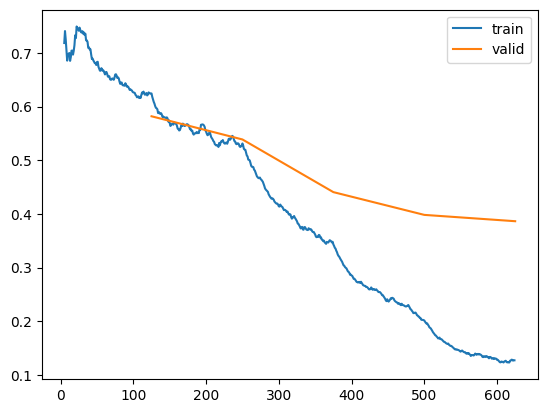

In [ ]:
learn.recorder.plot_loss()

El segundo tipo de procesamiento de lotes parece dar ligeramente mejores resultados, aunque por contra consume prácticamente el doble de GPU, lo cuál es casi anecdótico con este tamaño de imágenes y con un modelo pequeño, pero puede ser limitante si se dispone de una cantidad de GPU limitada.

###ConvNext

In [ ]:
arch2 = 'convnext_small_in22k'

Probamos la eficiencia de la nueva arquitectura con un entrenamiento de 5 épocas utlizando aug_transforms como técnica de aumento de datos.

In [ ]:
learn = train(arch2, item=Resize(256), batch=aug_transforms(size=128, min_scale=0.75))

/usr/local/lib/python3.10/dist-packages/timm/models/_factory.py:117: UserWarning: Mapping deprecated model name convnext_small_in22k to current convnext_small.fb_in22k.
  model = create_fn(


model.safetensors:   0%|          | 0.00/265M [00:00<?, ?B/s]

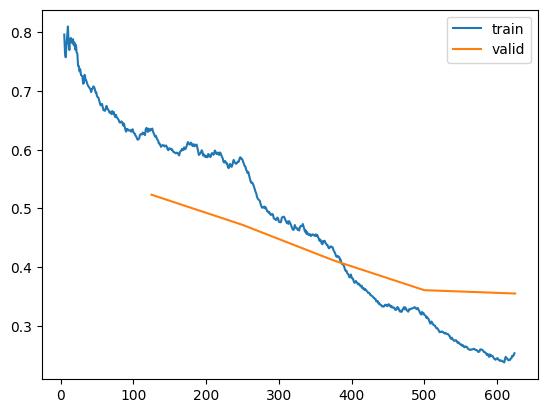

In [ ]:
learn.recorder.plot_loss()

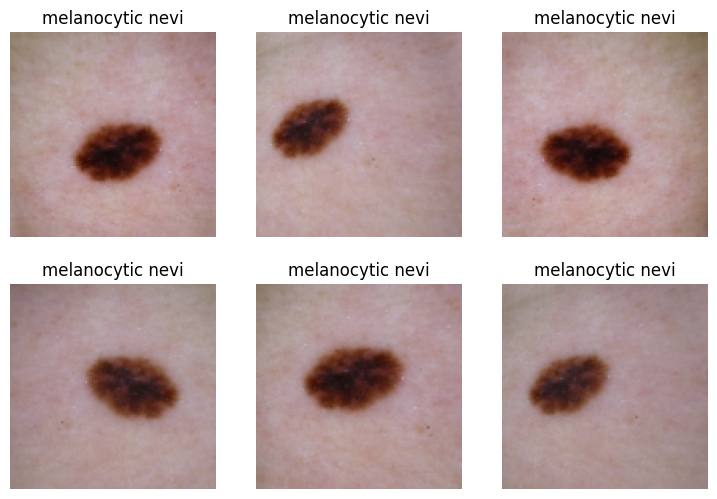

In [ ]:
learn.dls.train.show_batch(max_n=6, unique=True)

 Se aprecia un mejor rendimiento del modelo convnext respecto al resnet. Este último arroja unos mejores resultados, en precisión y especialmente en las tasas de pérdida en los conjuntos de entrenamiento y validación, que consigue disminuir notablemente.

Teniendo en cuenta lo anterior, en el siguiente apartado, en el que se probarán diferentes técnicas de preprocesado, **se utilizará el modelo convnext**.

###Prueba de diferentes técnicas de preprocesado

Probamos diferentes enfoques de preprocesado como el resize mediante squish o padding, para ver si se puede mejorar el rendimiento respecto al redimensionado por defecto.

####RandomResizedCrop

In [ ]:
learn = train(arch2, item=RandomResizedCrop(256), batch=aug_transforms(size=128, min_scale=0.75))

/usr/local/lib/python3.10/dist-packages/timm/models/_factory.py:117: UserWarning: Mapping deprecated model name convnext_small_in22k to current convnext_small.fb_in22k.
  model = create_fn(


model.safetensors:   0%|          | 0.00/265M [00:00<?, ?B/s]

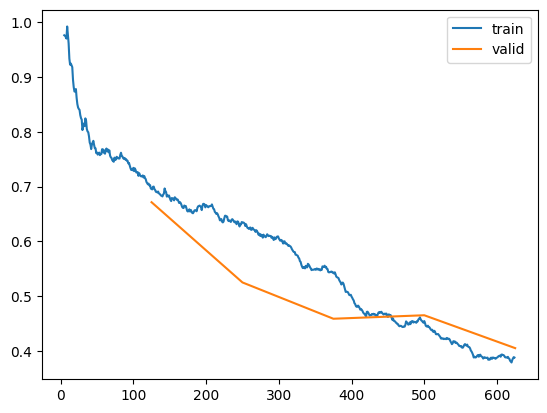

In [ ]:
learn.recorder.plot_loss()

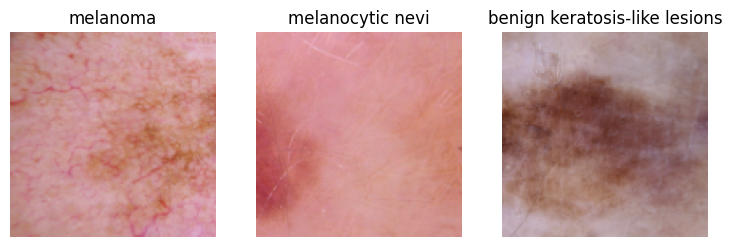

In [ ]:
learn.dls.show_batch(max_n=3)

#### Resize = squish

In [ ]:
learn = train(arch2, item=Resize(256,  method='squish'), batch=aug_transforms(size=128, min_scale=0.75))

/usr/local/lib/python3.10/dist-packages/timm/models/_factory.py:117: UserWarning: Mapping deprecated model name convnext_small_in22k to current convnext_small.fb_in22k.
  model = create_fn(


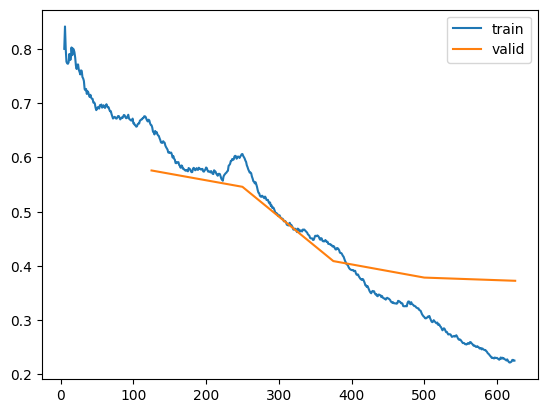

In [ ]:
learn.recorder.plot_loss()

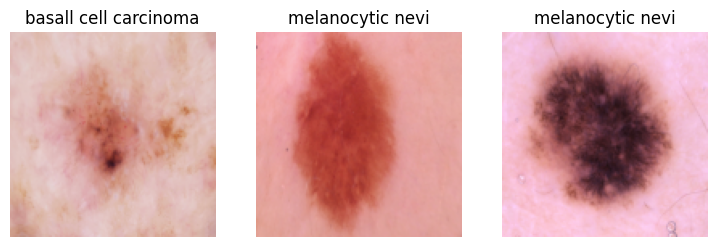

In [ ]:
learn.dls.show_batch(max_n=3)

####Padding

In [ ]:
learn = train(arch2, item=Resize((256), method=ResizeMethod.Pad, pad_mode=PadMode.Zeros),
      batch=aug_transforms(size=128))

/usr/local/lib/python3.10/dist-packages/timm/models/_factory.py:117: UserWarning: Mapping deprecated model name convnext_small_in22k to current convnext_small.fb_in22k.
  model = create_fn(


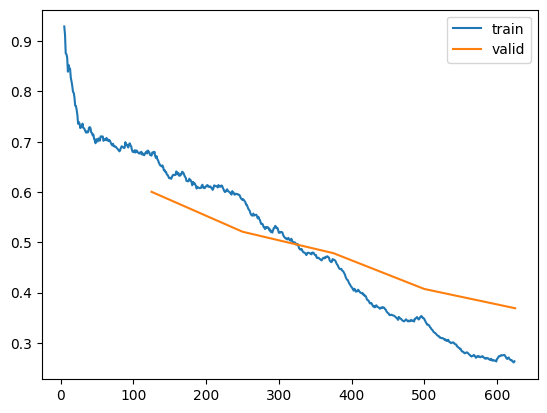

In [ ]:
learn.recorder.plot_loss()

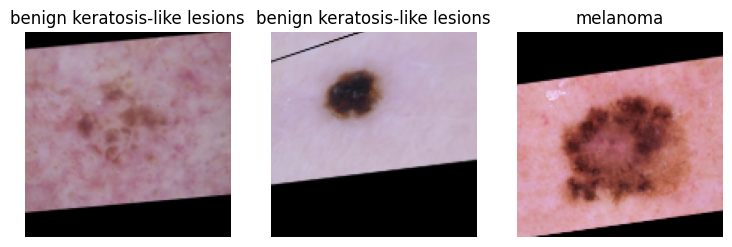

In [ ]:
learn.dls.show_batch(max_n=3)

#####**Croping + Dihedral**

Probamos una combinación de estrategias de preprocesamiento.

In [ ]:
learn = train(arch2, item=[Resize(256), DihedralItem()],
      batch=aug_transforms(size=(128), min_scale=0.75))

/usr/local/lib/python3.10/dist-packages/timm/models/_factory.py:117: UserWarning: Mapping deprecated model name convnext_small_in22k to current convnext_small.fb_in22k.
  model = create_fn(


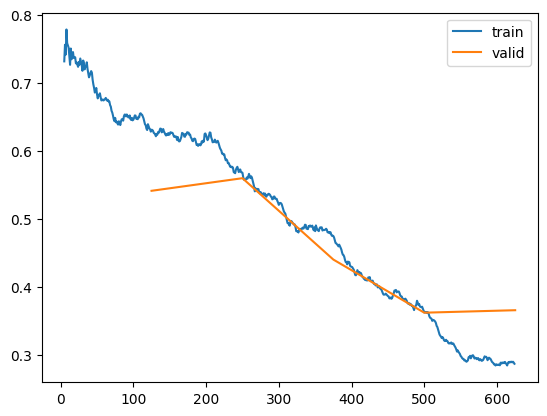

In [ ]:
learn.recorder.plot_loss()

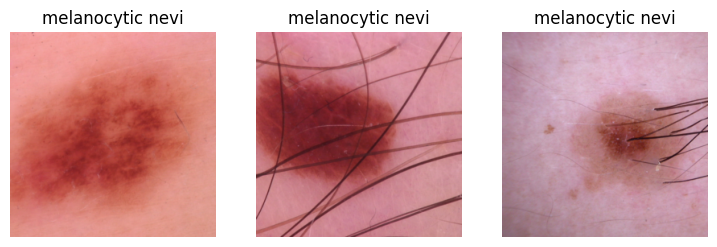

In [ ]:
learn.dls.show_batch(max_n=3)

####Prueba con Resize por defecto y RandomResizeCrop como técnica de aumento

In [ ]:
learn = train(arch2, item=Resize(256),
      batch=RandomResizedCrop(size=(128), min_scale=0.75))

/usr/local/lib/python3.10/dist-packages/timm/models/_factory.py:117: UserWarning: Mapping deprecated model name convnext_small_in22k to current convnext_small.fb_in22k.
  model = create_fn(


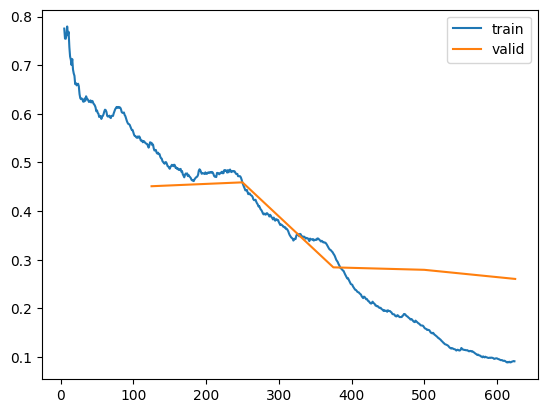

In [ ]:
learn.recorder.plot_loss()

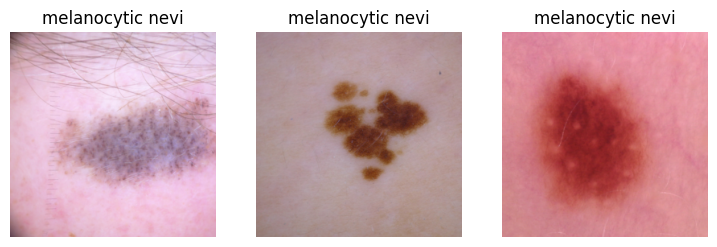

In [ ]:
learn.dls.show_batch(max_n=3)

Aunque se aumenta la precisión es importante destacar un aumento del consumo de la GPU de aproximadamente 6gb a 12gb

####Test Time Augmentation

Comprobamos el error_rate sin TTA

In [ ]:
valid = learn.dls.valid
preds,targs = learn.get_preds(dl=valid)

In [ ]:
error_rate(preds,targs)

TensorBase(0.0864)

In [ ]:
tta_preds,_ = learn.tta(dl=valid)

In [ ]:
error_rate(tta_preds, targs)

TensorBase(0.0809)

La reducción de la tasa de error es considerable en las cifras tan altas que nos movemos, por lo que añadiremos el TTA al procesamiento en modelos más grandes.

###Escalamos a un mayor tamaño de imágenes y un número mayor de epochs

Una vez elegida la estrategia de procesamiento que ha ofrecido mejores resultados, que sería el RandomResizedCrop para el procesamiento en lotes y el Resize default en el preprocesado, probamos con un tamaño de imágenes mayor, prácticamente la resolución original, y más épocas (12)

In [ ]:
def train(arch, size, lr=0.01, item=Resize(450), batch=RandomResizedCrop, accum=1, epochs=12):
  dls = DataBlock(
      blocks=(ImageBlock, CategoryBlock),
      get_items=get_image_files,
      splitter=RandomSplitter(valid_pct=0.2, seed=42),
      get_y=get_label,
      item_tfms=item,
      batch_tfms=batch(size=size, min_scale=0.75)).dataloaders(train_path, bs=64//accum)
  cbs = GradientAccumulation(64) if accum else []
  learn = vision_learner(dls, arch, metrics=[error_rate, accuracy], cbs=cbs).to_fp16()
  learn.fine_tune(epochs, lr)
  return learn

El consumo de la GPU será mayor por lo que se optó por utilizar la acumulación de gradiente (GradientAcumulation) y lotes más reducidos para no superar el límite.

####Prueba con RandomResizedCrop como técnica de aumento de datos

Se necesita implementar acumulación de gradiente para que no quedarnos sin gpu

In [ ]:
learn = train('convnext_small_in22k', 224,  accum=2)

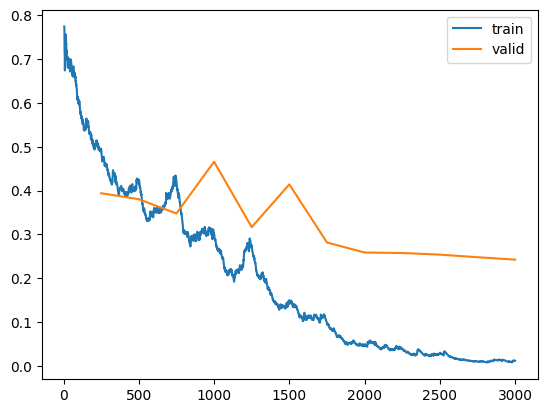

In [ ]:
learn.recorder.plot_loss()

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

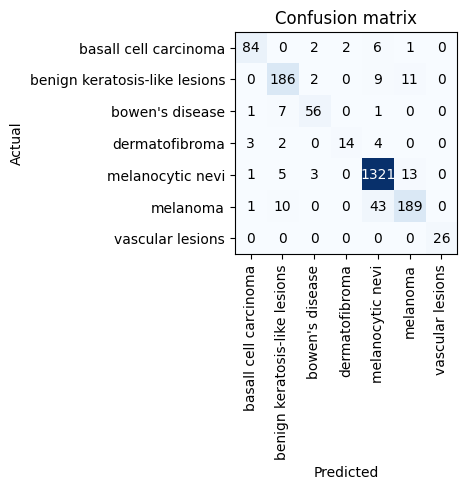

In [ ]:
interp.plot_confusion_matrix()

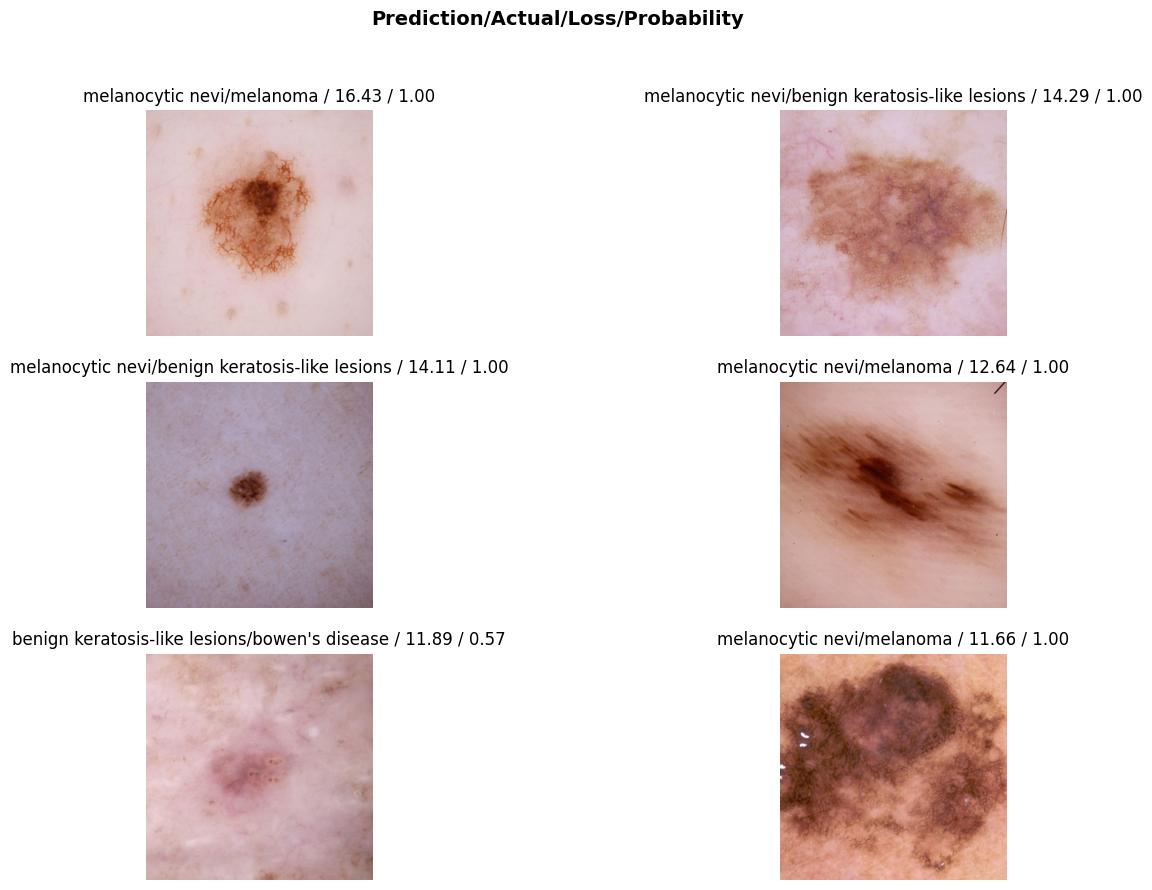

In [ ]:
interp.plot_top_losses(6, nrows=3, figsize=(15,10))

In [ ]:
learn.export('convnext_small_in22k')

#####Inferencia con el conjunto de test

In [ ]:
valid = learn.dls.valid
preds,targs = learn.get_preds(dl=valid)

In [ ]:
error_rate(preds,targs)

TensorBase(0.0629)

In [ ]:
tta_preds,targs = learn.tta(dl=learn.dls.valid)

In [ ]:
error_rate(tta_preds,targs)

TensorBase(0.0599)

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score

In [ ]:
def inference(learn):
  tst_dl = learn.dls.test_dl(tst_files)
  preds,_ = learn.tta(dl=tst_dl)
  idxs = preds.argmax(dim=1)
  vocab = np.array(learn.dls.vocab)
  results = pd.Series(vocab[idxs], name="idxs")
  ground_truth = pd.read_csv(path+'/test_ground_truth.csv')
  ground_truth['dx'] = ground_truth['dx'].str.lower().map(short_to_full_name_dict)
  targets = pd.Series(ground_truth['dx'])
  # accuracy: (tp + tn) / (p + n)
  accuracy = accuracy_score(targets, results)
  # precision tp / (tp + fp)
  precision = precision_score(targets, results, average='weighted')
  # recall: tp / (tp + fn)
  recall = recall_score(targets, results, average='weighted')
  # f1: 2 tp / (2 tp + fp + fn)
  f1 = f1_score(targets, results, average='weighted')
  return accuracy, precision, recall, f1


In [ ]:
accuracy, precision, recall, f1 = inference(learn)

In [ ]:
print('Accuracy: %f' % accuracy)
print('Precision: %f' % precision)
print('Recall: %f' % recall)
print('F1 score: %f' % f1)

Accuracy: 0.887566
Precision: 0.886905
Recall: 0.887566
F1 score: 0.885708


####Prueba con aug_transforms como técnica de aumento de datos

In [ ]:
learn = train('convnext_small_in22k', 224,
              item=Resize(450),
              batch=aug_transforms)

/usr/local/lib/python3.10/dist-packages/timm/models/_factory.py:117: UserWarning: Mapping deprecated model name convnext_small_in22k to current convnext_small.fb_in22k.
  model = create_fn(


model.safetensors:   0%|          | 0.00/265M [00:00<?, ?B/s]

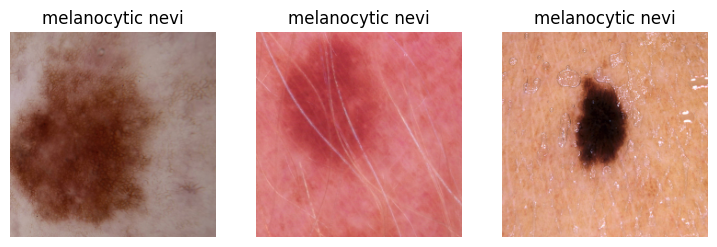

In [ ]:
learn.dls.show_batch(max_n=3)

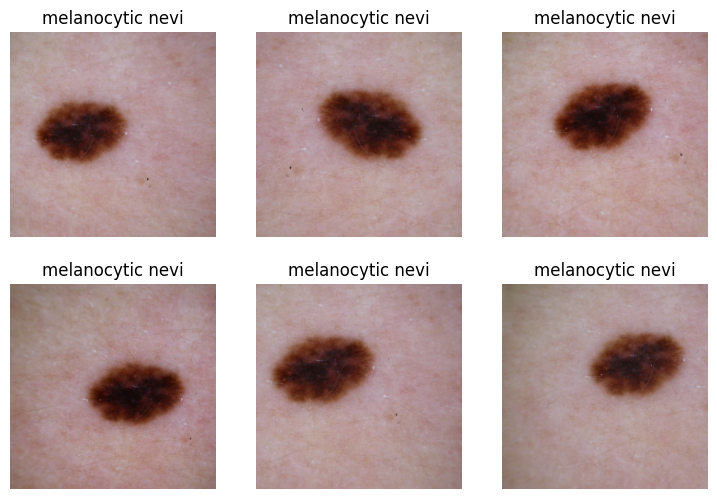

In [ ]:
learn.dls.train.show_batch(max_n=6, unique=True)

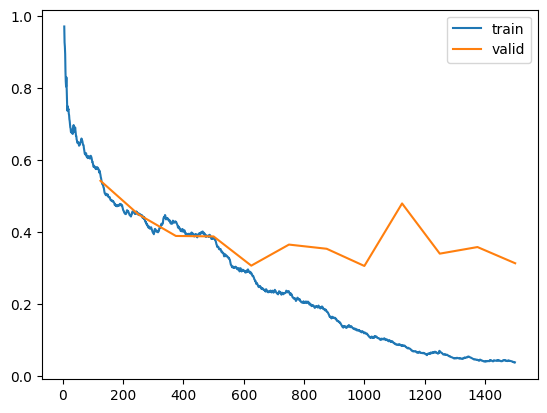

In [ ]:
learn.recorder.plot_loss()

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

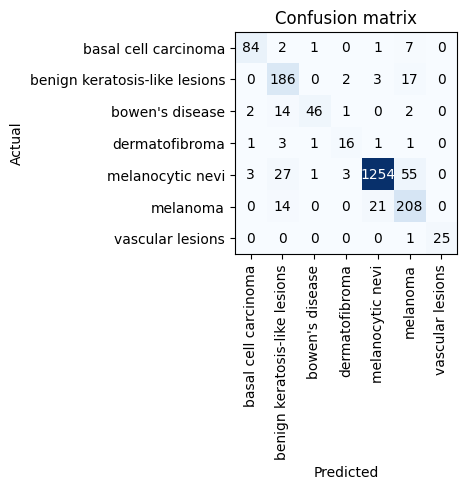

In [ ]:
interp.plot_confusion_matrix()

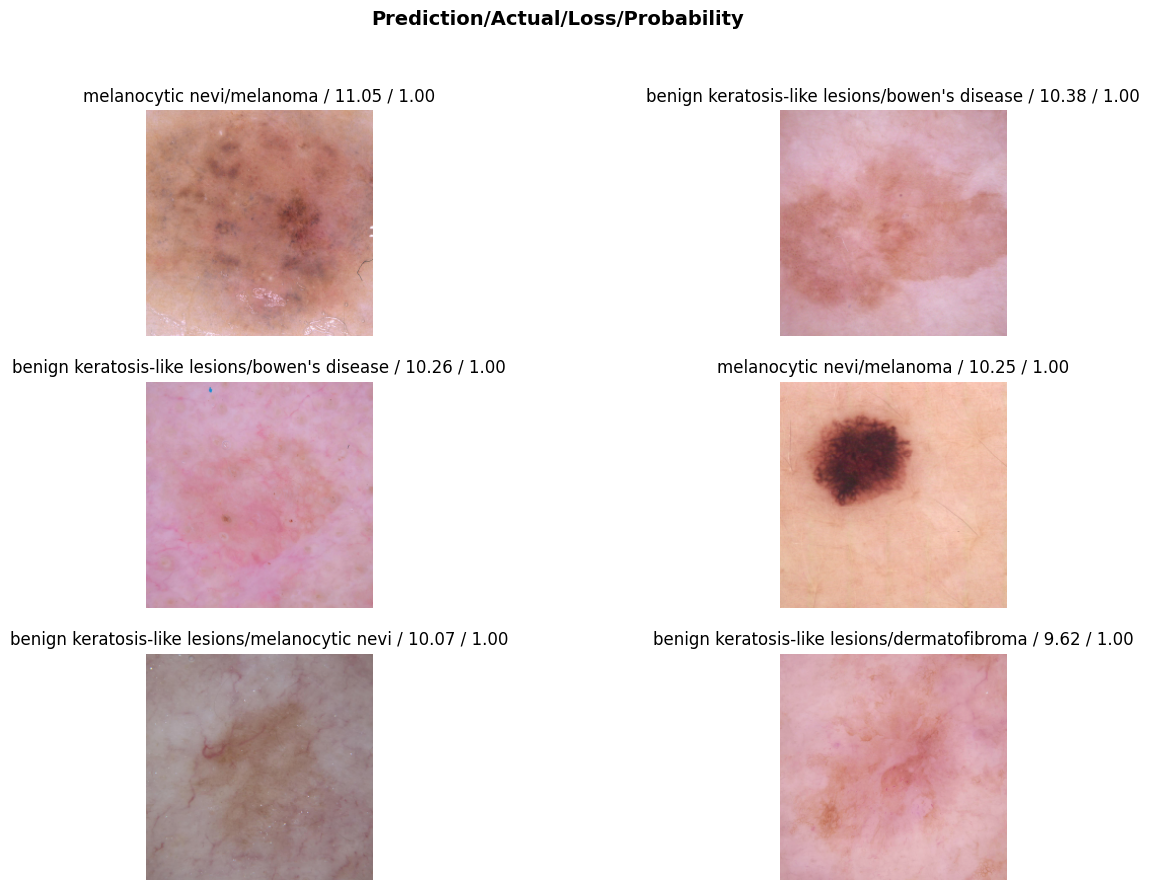

In [ ]:
interp.plot_top_losses(6, nrows=3, figsize=(15,10))

In [ ]:
valid = learn.dls.valid
preds,targs = learn.get_preds(dl=valid)

In [ ]:
error_rate(preds, targs)


TensorBase(0.0919)

In [ ]:
tta_preds,_ = learn.tta(dl=valid)

In [ ]:
error_rate(tta_preds, targs)

TensorBase(0.0709)

In [ ]:
inference(learn)

accuracy: 0.873677
precision: 0.870697
Recall: 0.873677
F1 score: 0.870794
Balanced accuracy: 0.758287


In [ ]:
learn.export('convnext_small_in22k_aug_transforms.pkl')

##**Modelos Más Grandes**

In [ ]:
import gc

In [ ]:
gc.collect()
torch.cuda.empty_cache()

In [ ]:
def train(arch, size, item=Resize(450), accum=1, epochs=12):
  dls = DataBlock(
      blocks=(ImageBlock, CategoryBlock),
      get_items=get_image_files,
      splitter=RandomSplitter(valid_pct=0.2),
      get_y=get_label,
      item_tfms=item,
      batch_tfms=aug_transforms(size=size, min_scale=0.75)).dataloaders(train_path, bs=64//accum)
  cbs = GradientAccumulation(64) if accum else []
  learn = vision_learner(dls, arch, metrics=[error_rate, accuracy], cbs=cbs).to_fp16()
  learn.fine_tune(epochs, 0.01)
  learn.recorder.plot_loss()
  return learn.tta(dl=dls.test_dl(tst_files))



In [ ]:
res = (600, 450)

In [ ]:
models = {
      'convnext_large_in22k': {
        (Resize(res), 224),
    }, 'vit_large_patch16_224': {
        (Resize(res), 224),
    }, 'swinv2_large_window12_192_22k': {
        (Resize(res), 192),
    }, 'swin_large_patch4_window7_224': {
        (Resize(res), 224),
    }
}

In [ ]:
tta_res = []

for arch,details in models.items():
    for item,size in details:
        print('---',arch)
        print(size)
        print(item.name)
        tta_res.append(train(arch, size, item=item, accum=2)) #, epochs=1))
        gc.collect()
        torch.cuda.empty_cache

--- convnext_large_in22k
224
Resize -- {'size': (450, 600), 'method': 'crop', 'pad_mode': 'reflection', 'resamples': (<Resampling.BILINEAR: 2>, <Resampling.NEAREST: 0>), 'p': 1.0}


--- vit_large_patch16_224
224
Resize -- {'size': (450, 600), 'method': 'crop', 'pad_mode': 'reflection', 'resamples': (<Resampling.BILINEAR: 2>, <Resampling.NEAREST: 0>), 'p': 1.0}


--- swinv2_large_window12_192_22k
192
Resize -- {'size': (450, 600), 'method': 'crop', 'pad_mode': 'reflection', 'resamples': (<Resampling.BILINEAR: 2>, <Resampling.NEAREST: 0>), 'p': 1.0}


/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Downloading: "https://github.com/SwinTransformer/storage/releases/download/v2.0.0/swinv2_large_patch4_window12_192_22k.pth" to /root/.cache/torch/hub/checkpoints/swinv2_large_patch4_window12_192_22k.pth


--- swin_large_patch4_window7_224
224
Resize -- {'size': (450, 600), 'method': 'crop', 'pad_mode': 'reflection', 'resamples': (<Resampling.BILINEAR: 2>, <Resampling.NEAREST: 0>), 'p': 1.0}


Downloading: "https://github.com/SwinTransformer/storage/releases/download/v1.0.0/swin_large_patch4_window7_224_22kto1k.pth" to /root/.cache/torch/hub/checkpoints/swin_large_patch4_window7_224_22kto1k.pth


In [ ]:
save_pickle('tta_res_ensemble_aug_.pkl', tta_res)

In [ ]:
tta_prs = first(zip(*tta_res))

In [ ]:
avg_pr = torch.stack(tta_prs).mean(0)
avg_pr.shape

torch.Size([1512, 7])

In [ ]:
idxs = avg_pr.argmax(dim=1)

In [ ]:
dls = DataBlock(
      blocks=(ImageBlock, CategoryBlock),
      get_items=get_image_files,
      splitter=RandomSplitter(valid_pct=0.2),
      get_y=get_label,
      item_tfms=Resize(450),
      batch_tfms=aug_transforms(size=224, min_scale=0.75)).dataloaders(train_path, bs=64)

In [ ]:
vocab = np.array(dls.vocab)

In [ ]:
results = pd.Series(vocab[idxs], name="idxs")
ground_truth = pd.read_csv(path+'/test_ground_truth.csv')
ground_truth['dx'] = ground_truth['dx'].str.lower().map(short_to_full_name_dict)
targets = pd.Series(ground_truth['dx'])
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(targets, results)
# precision tp / (tp + fp)
precision = precision_score(targets, results, average='weighted')
# recall: tp / (tp + fn)
recall = recall_score(targets, results, average='weighted')
f1 = f1_score(targets,results,average='weighted')

In [ ]:
print('Accuracy: %f' % accuracy)
print('Precision: %f' % precision)
print('Recall: %f' % recall)
print('F1 score: %f' % f1)

Accuracy: 0.896164
Precision: 0.893662
Recall: 0.896164
F1 score: 0.893797
